# Prepare data and libraries
Based on the Hospital Italiano de Buenos Aires - Skin Lesions Images (2019-2022).

* https://www.isic-archive.com/
* https://api.isic-archive.com/collections/251/

See separate EDA for downloading the metadata (cvs file) and imiages using the cli "isic" tool.

Criitically, this dataset has "skin type" using the Fitzpatrick scale.

* https://en.wikipedia.org/wiki/Fitzpatrick_scale

In [1]:
import sys
# If we have a version requirement, for no just make sure "more recent"
assert sys.version_info >= (3, 7)

In [2]:
# Not sure this is necessary, the data was put on mps but the model had to be explicitly put on mps
# Maybe adding this also puts the model on mps withouth having to issue following
#    model = model.to_device("mps")
#torch.set_default_device("mps")

In [3]:
# Change to top of the EFS mounted drive
import os
#os.chdir('/mnt/efs/fs1/')
!pwd

/Users/james/Documents/pytorch_test


In [4]:
## To load local modules, not sure if this works
#import os
#import sys
#module_path = os.path.abspath(os.path.join('..'))
#if module_path not in sys.path:
#    sys.path.append(module_path)

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms

(Optional) Define the default font sizes to make the figures prettier:

In [6]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [7]:
# If you have google colab gpu
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

zsh:1: command not found: nvidia-smi


In [8]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('Not using a high-RAM runtime')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 68.7 gigabytes of available RAM

You are using a high-RAM runtime!


# File/Folder Testing

The data was downloaded from the ISIC archive using the cli tool (need to iinstall this first).

See https://pypi.org/project/isic-cli/

See https://github.com/ImageMarkup/isic-cli

```
mkdir tone

cd tone

isic image download --search 'fitzpatrick_skin_type:I OR fitzpatrick_skin_type:II OR fitzpatrick_skin_type:III OR fitzpatrick_skin_type:IV OR fitzpatrick_skin_type:V OR fitzpatrick_skin_type:VI' .
```

In [9]:
!pwd

/Users/james/Documents/pytorch_test


In [10]:
#import skimage
import pathlib
import numpy as np

# This has all images from ISIC-HIBA (Argentina), skin_type is non-null (1616 images)
#csv_file_name='./hiba/HIBA_dataset.csv'
#meta_file_name='./hiba/SupplementaryData.csv'
#root_dir_name='./hiba/images'

# This has all images from ISIC where the, skin_type is non-null (3685 images)
# This includes the ISIC-HIBA (Argentina) images
csv_file_name='./tone/metadata.csv'
root_dir_name='./tone'

data_dir = pathlib.Path(root_dir_name) # NB: changing type froom str to Path
file_paths = list(data_dir.glob(f'*.jpg'))
image_count = len(file_paths)
print(f"image_count={image_count}")
for i in range(image_count):
    file_path = file_paths[i]
    print(f"file_path={file_path}")
    if( i > 10 ):
        break

image_count=3685
file_path=tone/ISIC_1908890.jpg
file_path=tone/ISIC_6066990.jpg
file_path=tone/ISIC_8165921.jpg
file_path=tone/ISIC_4767060.jpg
file_path=tone/ISIC_9465155.jpg
file_path=tone/ISIC_0851414.jpg
file_path=tone/ISIC_3410585.jpg
file_path=tone/ISIC_5732374.jpg
file_path=tone/ISIC_3199142.jpg
file_path=tone/ISIC_2785419.jpg
file_path=tone/ISIC_9918523.jpg
file_path=tone/ISIC_8521370.jpg


In [11]:
import pandas as pd
isic_metadata_df=pd.read_csv(csv_file_name)
isic_metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3685 entries, 0 to 3684
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   isic_id                 3685 non-null   object 
 1   attribution             3685 non-null   object 
 2   copyright_license       3685 non-null   object 
 3   acquisition_day         1846 non-null   float64
 4   age_approx              3684 non-null   float64
 5   anatom_site_general     3621 non-null   object 
 6   benign_malignant        3685 non-null   object 
 7   clin_size_long_diam_mm  649 non-null    float64
 8   concomitant_biopsy      3579 non-null   object 
 9   dermoscopic_type        1758 non-null   object 
 10  diagnosis               2340 non-null   object 
 11  diagnosis_confirm_type  3103 non-null   object 
 12  family_hx_mm            1409 non-null   object 
 13  fitzpatrick_skin_type   3685 non-null   object 
 14  image_type              3685 non-null   

In [12]:
isic_metadata_df.head()

,isic_id,attribution,copyright_license,acquisition_day,age_approx,anatom_site_general,benign_malignant,clin_size_long_diam_mm,concomitant_biopsy,dermoscopic_type,...,mel_thick_mm,mel_type,mel_ulcer,melanocytic,nevus_type,patient_id,personal_hx_mm,pixels_x,pixels_y,sex
0,ISIC_7559201,Memorial Sloan Kettering Cancer Center,CC-BY,2497.0,55.0,anterior torso,benign,6.6,NaN,contact non-polarized,...,NaN,NaN,NaN,True,NaN,IP_1238256,True,3264,2448,female
1,ISIC_0485014,Memorial Sloan Kettering Cancer Center,CC-BY,1.0,45.0,lower extremity,benign,NaN,NaN,contact non-polarized,...,NaN,NaN,NaN,True,NaN,IP_3227071,NaN,6000,4000,female
2,ISIC_5257439,Memorial Sloan Kettering Cancer Center,CC-BY,2360.0,40.0,lateral torso,benign,4.2,NaN,NaN,...,NaN,NaN,NaN,True,NaN,IP_7407753,True,3264,2448,female
3,ISIC_2989732,Memorial Sloan Kettering Cancer Center,CC-BY,78.0,80.0,anterior torso,benign,NaN,NaN,non-contact polarized,...,NaN,NaN,NaN,True,NaN,IP_2597637,NaN,6000,4000,male
4,ISIC_5638210,Memorial Sloan Kettering Cancer Center,CC-BY,78.0,80.0,anterior torso,benign,NaN,NaN,contact non-polarized,...,NaN,NaN,NaN,True,NaN,IP_2597637,NaN,6000,4000,male


### Drop rows that do not have skin type

In [13]:
isic_metadata_df = isic_metadata_df[isic_metadata_df['fitzpatrick_skin_type'].notna()]

### There are four categories 
* benign
* malignant
* indeterminate/benign
* indeterminate/benign

Drop rows that are not benign or malignant.

In [14]:
def filter_rows_without_values(df, col, values):
    return df[~df[col].isin(values)]

In [15]:
def filter_rows_with_values(df, col, values):
    return df[df[col].isin(values)]

In [16]:
isic_metadata_df = filter_rows_with_values(isic_metadata_df, 'benign_malignant', ['benign', 'malignant'] )

### Add new feature based on fitzpatrick_skin_type, this will become the new target, converts from 6 multiclassification into a binary classfication

In [17]:
def convert_type2tone(row):
    # returns 0 meaning light tone, and 1 meaning dark tone
    #print(f"{row['fitzpatrick_skin_type']}")
    if row['fitzpatrick_skin_type'] == "I" or row['fitzpatrick_skin_type'] == "II":
        # Types I and II are "light" skin
        #row['tone'] = 0
        return 'light'
    else:
        #row['tone'] = 1
        return 'dark'

isic_metadata_df["skin_tone"] = isic_metadata_df.apply( convert_type2tone, axis=1 )
#isic_metadata_df.describe(include='all')
isic_metadata_df

,isic_id,attribution,copyright_license,acquisition_day,age_approx,anatom_site_general,benign_malignant,clin_size_long_diam_mm,concomitant_biopsy,dermoscopic_type,...,mel_type,mel_ulcer,melanocytic,nevus_type,patient_id,personal_hx_mm,pixels_x,pixels_y,sex,skin_tone
0,ISIC_7559201,Memorial Sloan Kettering Cancer Center,CC-BY,2497.0,55.0,anterior torso,benign,6.6,NaN,contact non-polarized,...,NaN,NaN,True,NaN,IP_1238256,True,3264,2448,female,dark
1,ISIC_0485014,Memorial Sloan Kettering Cancer Center,CC-BY,1.0,45.0,lower extremity,benign,NaN,NaN,contact non-polarized,...,NaN,NaN,True,NaN,IP_3227071,NaN,6000,4000,female,light
2,ISIC_5257439,Memorial Sloan Kettering Cancer Center,CC-BY,2360.0,40.0,lateral torso,benign,4.2,NaN,NaN,...,NaN,NaN,True,NaN,IP_7407753,True,3264,2448,female,light
3,ISIC_2989732,Memorial Sloan Kettering Cancer Center,CC-BY,78.0,80.0,anterior torso,benign,NaN,NaN,non-contact polarized,...,NaN,NaN,True,NaN,IP_2597637,NaN,6000,4000,male,light
4,ISIC_5638210,Memorial Sloan Kettering Cancer Center,CC-BY,78.0,80.0,anterior torso,benign,NaN,NaN,contact non-polarized,...,NaN,NaN,True,NaN,IP_2597637,NaN,6000,4000,male,light
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3680,ISIC_2797668,Sydney Melanoma Diagnostic Center at Royal Pri...,CC-BY-NC,95.0,40.0,lower extremity,benign,NaN,False,NaN,...,NaN,NaN,NaN,NaN,IP_0412224,NaN,5184,3456,female,light
3681,ISIC_6349205,Sydney Melanoma Diagnostic Center at Royal Pri...,CC-BY-NC,NaN,75.0,head/neck,benign,NaN,False,NaN,...,NaN,NaN,NaN,NaN,IP_6312474,NaN,5184,3456,male,light
3682,ISIC_1054769,Sydney Melanoma Diagnostic Center at Royal Pri...,CC-BY-NC,NaN,20.0,posterior torso,benign,NaN,False,NaN,...,NaN,NaN,NaN,NaN,IP_7377609,NaN,5184,3456,male,dark
3683,ISIC_4068636,Sydney Melanoma Diagnostic Center at Royal Pri...,CC-BY-NC,NaN,40.0,lower extremity,benign,NaN,True,NaN,...,NaN,NaN,True,combined,IP_6911447,NaN,5184,3456,male,light


In [18]:
#example_metadata = lookup_img_path( isic_metadata_df, "./hiba/images/ISIC_9999251.JPG" )
#print(example_metadata)

### Take sub-sample for development (roughly 3600 images at 20 epochs takes 8 hours to train)

In [19]:
# First see how balanced our classes are
print( f"Total rows {len( isic_metadata_df )}" )
print( isic_metadata_df["skin_tone"].value_counts() / len( isic_metadata_df ) )
print( isic_metadata_df["benign_malignant"].value_counts() / len( isic_metadata_df ) )

Total rows 3623
skin_tone
light    0.833287
dark     0.166713
Name: count, dtype: float64
benign_malignant
benign       0.747171
malignant    0.252829
Name: count, dtype: float64


In [20]:
# Function to randomly take samples for each class
# Returns new dataframe with sample subset of df
def sample_dataframe(df, class_name, no_sample):
    #no_sample = 5
    balanced_df = df.groupby(
        class_name,
        as_index=False,
        group_keys=False
      ).apply( lambda s: s.sample(no_sample,replace=True)
    )
    return balanced_df

### Shuffle the dataframe and reset index (has original, do dnot believe we need to keep?)

In [21]:
isic_metadata_df = isic_metadata_df.sample(frac=1) # effectively shuffle
isic_metadata_df = isic_metadata_df.reset_index(drop=True)
isic_metadata_df

,isic_id,attribution,copyright_license,acquisition_day,age_approx,anatom_site_general,benign_malignant,clin_size_long_diam_mm,concomitant_biopsy,dermoscopic_type,...,mel_type,mel_ulcer,melanocytic,nevus_type,patient_id,personal_hx_mm,pixels_x,pixels_y,sex,skin_tone
0,ISIC_1935605,Hospital Italiano de Buenos Aires,CC-BY,NaN,75.0,head/neck,malignant,NaN,True,contact polarized,...,NaN,NaN,NaN,NaN,IP_2363839,NaN,4032,3024,male,light
1,ISIC_8144271,Sydney Melanoma Diagnostic Center at Royal Pri...,CC-BY-NC,204.0,70.0,anterior torso,benign,NaN,False,NaN,...,NaN,NaN,NaN,NaN,IP_3045056,NaN,2317,2317,male,light
2,ISIC_5329981,Sydney Melanoma Diagnostic Center at Royal Pri...,CC-BY-NC,99.0,25.0,lower extremity,benign,NaN,False,NaN,...,NaN,NaN,NaN,NaN,IP_1921028,NaN,5184,3456,male,light
3,ISIC_0676126,Sydney Melanoma Diagnostic Center at Royal Pri...,CC-BY-NC,106.0,50.0,posterior torso,benign,NaN,False,NaN,...,NaN,NaN,NaN,NaN,IP_2105363,NaN,5184,3456,male,light
4,ISIC_5196989,Sydney Melanoma Diagnostic Center at Royal Pri...,CC-BY-NC,106.0,50.0,head/neck,benign,NaN,False,NaN,...,NaN,NaN,NaN,NaN,IP_3078108,NaN,6000,4000,male,light
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3618,ISIC_4635075,Hospital Italiano de Buenos Aires,CC-BY,NaN,35.0,posterior torso,benign,NaN,False,contact polarized,...,NaN,NaN,NaN,NaN,IP_9328831,False,1920,1080,female,light
3619,ISIC_6585351,Hospital Italiano de Buenos Aires,CC-BY,NaN,30.0,palms/soles,benign,NaN,True,contact polarized,...,NaN,NaN,NaN,NaN,IP_1749049,NaN,3024,4032,female,light
3620,ISIC_1831970,Hospital Italiano de Buenos Aires,CC-BY,NaN,50.0,anterior torso,malignant,NaN,True,NaN,...,NaN,NaN,NaN,NaN,IP_4253242,False,610,486,female,light
3621,ISIC_8998096,Hospital Italiano de Buenos Aires,CC-BY,NaN,35.0,palms/soles,benign,NaN,False,contact polarized,...,NaN,NaN,NaN,NaN,IP_2738413,NaN,3024,4032,female,light


## 1. Custom Dataset
Based on https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

Based on https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [22]:
# Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Set the device      
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Is MPS (Metal Performance Shader) built? True
Is MPS available? True
Using device: mps


In [23]:
import pathlib
import numpy as np

In [24]:
import pathlib
from torch.utils.data import Dataset
#from torchvision.io import read_image

# Three ways of reading images (two in the tutorials)
# Transforms are designed for Scikit-image, however, decided to use Torchvision
# Torchvision returns tensor (can be converted to PIL for displaying)
# Scikit-image returns numpy skimage.io.imread(os.path.join('data/faces/', img_name)
# PIL returns pillow object me thinks PIL.Image.open(image_path)
# https://stackoverflow.com/questions/68207510/how-to-use-torchvision-io-read-image-with-image-as-variable-not-stored-file
#import skimage

# NB: Typical image dataset returns (image,label)
#     Our implementation returns (image,label,index)

import pandas as pd
import os

class HibaDataset(Dataset):
    """Hiba dataset"""

    def __init__(self, p_metadata_df, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the (JPG) images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.metadata_df = p_metadata_df
        #self.metadata_df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

        # Drop  rows that do not have skin type
        #self.metadata_df = self.metadata_df[self.metadata_df['fitzpatrick_skin_type'].notna()]

        # Drop rows that do not have benign or malignant 
        #self.metadata_df = filter_rows_with_values(self.metadata_df, 'benign_malignant', ['benign', 'malignant'] )
        
        # Add new binary feature based on skin_type
        #self.metadata_df["skin_tone"] = self.metadata_df.apply( convert_type2tone, axis=1 )

        # Sample so that model target feature are balanced (bias feature remains unbalanced)
        #self.metadata_df = sample_dataframe(self.metadata_df, "benign_malignant", 500)
        
        
        self.image_count = len(self.metadata_df)
        #print(f"image_count = {image_count}")
        #for i in range(image_count):
        #    file_path = file_paths[i]

        # What target are we trying to predict?
        # Manually map target to ints   (required for models)
        self.class_names = ['benign', 'malignant']
        #self.class_names = ['I', 'II', 'III', 'IV' , 'V', 'VI']
        #self.class_names = ['light', 'dark']
        
    
    def __len__(self):
        return self.image_count

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        instance = self.lookup_path( idx )
        file_path = self.get_file_path( instance["image_name"] )

        #img_name = sample['imgid']
        #image = io.imread(img_name)
        # Frankly not sure why we don't just store as Pytorch tensor
        # example stores as a numpy image and then transforms
        # In any cases, the dimensions are different and so code is not compatible
        # specifically the resize and crop are written for numpy :(
        # Perhaps one day can rewrite for tensors but fine for now
        #image_tensor = torchvision.io.read_image( str(file_path) )
        #sample['image'] = image_tensor
        
        image_np = skimage.io.imread(file_path) # dtype=uint8
        # [[[209 155 181]
        #  [210 154 183]
        #  [209 154 183]
        #  ...
        # need float32, also imshow, if float, expects  between [0,1]
        # This is also perhaps nice for training as normalised.
        image_np = np.float32(image_np)/255.0

        # Change  the target from {benign,malignant} to the skin_type {I,II,III,IV,V,VI}
        label = self.class_names.index( instance['benign_malignant'] )
        #label = self.class_names.index( row['skin_type'] )
        #label = self.class_names.index( row['skin_tone'] )
        # NB: the label is index of the target name
        # NB: tuple has to be tensors or numbers, cannot include the instance :(
        sample = (image_np, label, idx)

        # apply any transforms, e.g. resize, crop
        if self.transform:
            sample = self.transform(sample)

        return sample

    def get_class_names( self ):
        return self.class_names

    def get_class( self, index ):
        return self.class_names[index]

    def get_file_path( self, image_name ):
        #sample = self.lookup_path(idx)
        #image_name = sample["image_name"]
        # Need to put together filepath
        filepath = os.path.join( self.root_dir, image_name+".jpg" )
        return filepath
    
    def lookup_path( self, idx ):
        """
        index of the instance (e.g. ISIC_0034214) in the dataframe
        returns dict {'file_path','image_name','patient_id','diagnosis',
            'benign_malignant', 'age', 'sex', 'location', 'skin_type'}
        """
        
        row = self.metadata_df.iloc[idx]

        #print( f"row type = {type(row)}" )
        #print( row )
        # the self.metadata_df.iloc[idx] returns a pandas Series
        # basically a dictionary for one row of datframe
        patient_id = row["patient_id"]
        image_name = row["isic_id"]
        diagnosis  = row["diagnosis"]
        benign     = row["benign_malignant"]
        age        = row["age_approx"]
        sex        = row["sex"]
        location   = row["anatom_site_general"]
        skin_type  = row["fitzpatrick_skin_type"]
        skin_tone  = row["skin_tone"]
    
        instance = {'file_path': file_path, 'image_name': image_name, 'patient_id': patient_id,
                  'diagnosis': diagnosis, 'benign_malignant': benign, 'age': age, 'sex': sex,
                  'location': location, 'skin_type':skin_type, 'skin_tone':skin_tone}
        return instance

In [25]:
import skimage
def show_skin_image(image_np):
    """Show image"""
    plt.imshow(image_np)
    
    #new_PIL_image = transform.to_pil_image(image_tensor) 
    #plt.imshow(new_PIL_image)
    
    #plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

#plt.figure()
#image_np = skimage.io.imread('hiba/images/ISIC_9999251.JPG')
#image_np = np.float32(image_np)/255.0
##pixel values are either between [0,255] or [0.0,1.0]
## Since we nornalised, they are [0.0,1.0]
#show_skin_image(image_np)
#plt.show()
#print(image_np.dtype)

images in dataset = 3623
i=0, image shape=(3024, 4032, 3), label=1


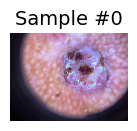

i=1, image shape=(2317, 2317, 3), label=0


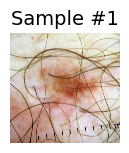

i=2, image shape=(3456, 5184, 3), label=0


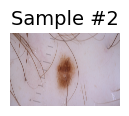

i=3, image shape=(3456, 5184, 3), label=0


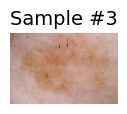

In [26]:
#isic_dataset = IsicDataset(csv_file=csv_file_name, root_dir=root_dir_name)
#isic_dataset = HibaDataset(csv_file=csv_file_name, root_dir=root_dir_name)
isic_dataset = HibaDataset(isic_metadata_df, root_dir=root_dir_name)

fig = plt.figure()

print(f"images in dataset = {len(isic_dataset)}")

images_to_show = 4
for i, sample in enumerate(isic_dataset):
    image_tensor, label, index = sample
    #print(i, image_tensor.shape, label)
    # Note that index and i are the same
    # We need to add the index so we can retrieve when using batches (i is not part of batch)
    print(f"i={i}, image shape={image_tensor.shape}, label={label}")
    
    ax = plt.subplot(1, images_to_show, i + 1)
    plt.tight_layout()
    ax.set_title(f'Sample #{i}')
    ax.axis('off')
    show_skin_image( image_tensor )
    
    if i == images_to_show -  1:
        plt.show()
        break

In [27]:
import numpy as np
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        # output_size to rescale the image to
        self.output_size = output_size

    def __call__(self, sample):
        image, label, index = sample

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = skimage.transform.resize(image, (new_h, new_w))

        return (img, label, index)


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, label, index = sample

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h + 1)
        left = np.random.randint(0, w - new_w + 1)

        image = image[top: top + new_h,
                      left: left + new_w]

        return (image, label, index)


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label, index = sample

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        #print(image_np.dtype) = uint8
        # default numpy type is float64, causes issues as models expect float32 :(
        return (torch.from_numpy(image), label, index)

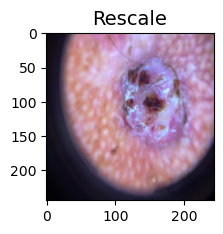

In [28]:
#from torchvision.transforms import v2

#scale = Rescale(256)
scale = Rescale( (244,244) )
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = isic_dataset[0]
#for i, tsfrm in enumerate([scale, crop, composed]):
for i, tsfrm in enumerate([scale]):
    image, label, index = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_skin_image(image)

plt.show()

Iterating through the dataset
Let’s put this all together to create a dataset with composed transforms. To summarize, every time this dataset is sampled:

An image is read from the file on the fly

Transforms are applied on the read image

Since one of the transforms is random, data is augmented on sampling

We can iterate over the created dataset with a for i in range loop as before.

In [29]:
transformed_dataset = HibaDataset( isic_metadata_df,
                                   root_dir=root_dir_name,
                                   transform=transforms.Compose([
                                       Rescale( (224,224) ),
                                       #RandomCrop(224),
                                       ToTensor()
                                    ]))

for i, sample in enumerate(transformed_dataset):
    image, label, index = sample
    print(i, image.size())

    if i == 3:
        break

0 torch.Size([3, 224, 224])
1 torch.Size([3, 224, 224])
2 torch.Size([3, 224, 224])
3 torch.Size([3, 224, 224])


However, we are losing a lot of features by using a simple for loop to iterate over the data. In particular, we are missing out on:

Batching the data

Shuffling the data

Load the data in parallel using multiprocessing workers.

torch.utils.data.DataLoader is an iterator which provides all these features. Parameters used below should be clear. One parameter of interest is collate_fn. You can specify how exactly the samples need to be batched using collate_fn. However, default collate should work fine for most use cases.

In [30]:
from torch.utils.data import DataLoader
from torchvision import utils

# Create function to show the images in a batch from a dataloader
# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, labels_batch, indexes = sample_batched
    batch_size = len(images_batch)
    #print(f"batch_size={batch_size}")
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

In [31]:
# Define optimisation parameters
#   tune the num_threads to your CPU
#   tune the batch size to your RAM
num_threads = 0 # assuming 16 CPUs
#batch_size = 16
batch_size = 32

In [32]:
# This dataloader is an example only, we split the dataset later and use the train and test loaders
# Said another way, you can safely skip this
dataloader = DataLoader(transformed_dataset, batch_size=batch_size, shuffle=True)


0 3
1 3
2 3
3 3


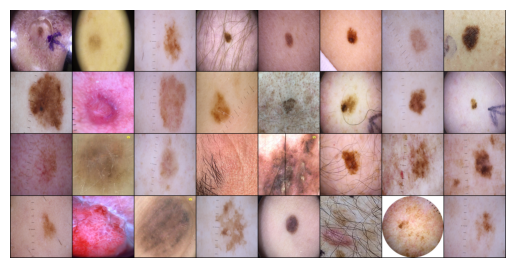

In [33]:
# https://github.com/pytorch/pytorch/issues/60319
# https://www.reddit.com/r/MLQuestions/comments/n9iu83/pytorch_lightning_bert_attributeerror_cant_get/?rdt=51343

# if you are using Windows, uncomment the next line and indent the for loop.
# you might need to go back and change ``num_workers`` to 0.

#if __name__ == '__main__':
for i_batch, sample_batched in enumerate(dataloader):
    # NB sample_batched should always be 2, two lists
    #   list of batch_size for images
    #   list of batch_size for labels
    print(i_batch, len(sample_batched) ) 
    
    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

### Split the dataset into train and test datasets (each will also have associated dataloader).  Note that perhaps a better name for Dataloader is Batcher as it is where the batches are produced.

In [ ]:
class_names = transformed_dataset.get_class_names()

total = len(transformed_dataset)
train = int(0.7 * total)
test  = total - train
print(  f"class_names={class_names} target size {len(class_names)}" )
print(  f"train={train}  test={test}" )
train_set, test_set = torch.utils.data.random_split(transformed_dataset, [train, test])

# I removed the, num_workers=num_threads, seems to cause more performance issues than help
trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
testloader  = DataLoader(test_set,  batch_size=batch_size, shuffle=True)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels, indexes = next(dataiter)


# show images
imshow(torchvision.utils.make_grid(images))
# print labels
label_list = list()
for j in range(batch_size):
    label_list.append(class_names[labels[j]])
    if (j+1) % 8 == 0:
        print(' '.join(label_list) )
        label_list.clear()
#print(' '.join(f'{class_names[labels[j]]:5s}' for j in range(batch_size)))

# 2. Define a Custom Model (Convolutional Neural Network)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Expects images of h=224, w=224
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7, stride=1, padding='same')
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same')
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2))

        self.flat = nn.Flatten()

        # 28 = 224 / 2/ 2 /2 
        self.fc4 = nn.Linear(128*28*28, 512)
        self.act4 = nn.ReLU()
        self.drop4 = nn.Dropout(0.5)

        self.fc5 = nn.Linear(512, 256)
        self.act5 = nn.ReLU()
        self.drop5 = nn.Dropout(0.5)

        self.fc6 = nn.Linear(256, len(class_names))
        # Omitted because loss function 
        #self.softmax = nn.Softmax( dim=len(class_names) ) # expect  only one dim

        # Initialise
        self._init_weights(self.conv1)
        self._init_weights(self.conv2)
        self._init_weights(self.conv3)
        self._init_weights(self.fc4)
        self._init_weights(self.fc5)
        self._init_weights(self.fc6)
        #self._init_weights(self.softmax)

    def _init_weights(self, module):
        #print(f"Initialising module {module}")
        # https://saturncloud.io/blog/how-to-initialize-weights-in-pytorch-a-guide-for-data-scientists/
        # https://wandb.ai/wandb_fc/tips/reports/How-to-Initialize-Weights-in-PyTorch--VmlldzoxNjcwOTg1
        nn.init.xavier_normal_(module.weight)
        # nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu') # He
        #if isinstance(module, nn.Linear):
        #    module.weight.data.normal_(mean=0.0, std=1.0)
        #    if module.bias is not None:
        #        module.bias.data.zero_()

    
    def forward(self, x):
        verbose = False
        #=========================#
        # input 3x224x224
        x = self.act1(self.conv1(x))
        # output 32x224x224

        # input 32x224x224 
        x = self.pool1(x)
        # output 32x112x112
        if verbose: print(f"output conv1 {x.shape}")

        #=========================#
        # input 32x112x112
        x = self.act2(self.conv2(x))
        # input 64x112x112
        
        # input 64x112x112
        x = self.pool2(x)
        # output 64x56x56
        if verbose: print(f"output conv2 {x.shape}")

        #=========================#
        # input 64x56x56
        x = self.act3(self.conv3(x))
        # input 128x56x56
        
        # input 128x56x56
        x = self.pool3(x)
        # output 128x28x28
        if verbose: print(f"output conv3 {x.shape}")

        #=========================#
        # input 128x28x28
        x = self.flat(x)
        # output (128x28x28)
        if verbose: print(f"output flatten {x.shape}")

        #=========================#
        # input (128x28x28)
        x = self.act4(self.fc4(x))
        x = self.drop4(x)
        # output (512)
        if verbose: print(f"output fully connect 4 {x.shape}")

        #=========================#
        # input (512)
        x = self.act5(self.fc5(x))
        x = self.drop5(x)
        #  output (256)
        if verbose: print(f"output fully connect 5 {x.shape}")

        #=========================#
        # input (256)
        x = self.fc6(x)
        #  output (7)
        if verbose: print(f"output fully connect 6 {x.shape}")
        
        # Finally pass through a softmax
        #x = self.softmax(x)
        #if verbose: print(f"output softmax {x.shape}")
        return x


# 3. Train the model

1. Import common modules
2. Define generic train function
3. Define generic train visualise function
4. Train (either transfer or custom model, only both if need comparisons)
    1. transfer model
    2. custom model
5. Evaluate on testset
6. Fairness evalation
7. Exploratory data analysis (does not need the model, only the dataframe)

In [ ]:
# Common imports for training
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
import time
from tempfile import TemporaryDirectory

import torch.optim as optim


### Define the device (GPU or CPU).
Just like how you transfer a Tensor onto the GPU, you transfer the neural net onto the GPU.

Let’s first define our device as the first visible cuda device if we have CUDA available:

In [ ]:
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

### Training based on https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

Crazy, there is a bug in the generic train function, len(dataloader) returns number of batches

The example tried to compute the accuracy using wrong denominator!!!  Should be len(dataloader.dataset)

See https://discuss.pytorch.org/t/what-is-len-dataloader-equal-to/52472

### Generic torch training loop with 'train' and (optional) 'val' dataloaders.

Implements typical torch training and test procedures.  Properly sets model in 'train' and 'eval' for the val dataloader.  If both 'train' and 'val' dataloaders are passed, then will return model with the best (ie highest accuracy) during epoch training.

In [ ]:
#dataloaders = {'train': trainloader, 'val': testloader }
# dataloaders should be a dict with 'train' and/or 'val' dataloaders
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            #for phase in ['train', 'val']:
            for phase in dataloaders.keys():
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                batch = 0
                dataloader = dataloaders[phase]
                for inputs, labels, indexes in dataloader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    #running_loss += loss.item() * inputs.size(0)
                    #running_corrects += torch.sum(preds == labels.data)
                    
                    correct = torch.sum(preds == labels.data) # correct predictions in the batch
                    
                    running_loss += loss.item()
                    running_corrects += correct
                    if( batch % 16 == 0 ):
                        print(f'  epoch {epoch+1} batch {batch}:  running_corrects {running_corrects} loss: {running_loss:.6f}')
                        #print(f'       pred: {preds}')
                        #print(f'     labels: {labels}')
                        #print(f'    correct: {correct}')
                    batch += 1
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / len(dataloader)
                #epoch_acc = running_corrects.double() / len(dataloader)
                epoch_acc = running_corrects / len(dataloader.dataset)

                #print(f'Summary: running_corrects {running_corrects} / {len(dataloader.dataset)} = {epoch_acc:.2f}')

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        #model.load_state_dict(torch.load(best_model_params_path))
    return model

### Generic function to display predictions for a few images

In [ ]:
def visualize_model(model, dataloader, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            inputs, labels, indexes = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}  actual: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


### Transfer learning attempt, not yet using but need to give a try

Choose either this approach or the custom model (below), no need to traini both unless you want to compare.

In [ ]:
model_transfer = models.resnet18()
num_ftrs = model_transfer.fc.in_features
# Here the size of each output sample is set to number of classes to predict, in our case 2.
model_transfer.fc = nn.Linear(num_ftrs, len(class_names))

model_transfer = model_transfer.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_transfer.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
##dataloaders = {'train': trainloader, 'val': testloader }
#dataloaders = {'train': trainloader}
#train_model(model_transfer, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=1)

### Train our custom model

In [ ]:
# Create the mode and training objects
model = Net()
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
# Need to put model and data onto device
# To my knowledge this puts entire model into GPU/TPU
model = model.to(device)
# Also need to put data onto device, that this is done in the train_model loop

In [ ]:
dataloaders = {'train': trainloader}
#dataloaders = {'val': testloader}
#NB: returns "best model',  so need to overwrite passed in model
train_model(model, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=1)

In [ ]:
visualize_model(model, testloader, num_images=5)

### Save the trained model:

In [ ]:
PATH = './hiba_benign_malignant.pth'
torch.save(model.state_dict(), PATH)

## 5. Test the network on the test data
We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

In [ ]:
dataiter = iter(testloader)
images, labels, indexes = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{class_names[labels[j]]:5s}' for j in range(batch_size)))

Next, let’s load back in our saved model (note: saving and re-loading the model wasn’t necessary here, we only did it to illustrate how to do so):

In [ ]:
model = Net()
model.eval()
model.load_state_dict(torch.load(PATH))

# Put model into GMU/TPU (aka MDS)
#model = model.to(device)

Okay, now let us see what the neural network thinks these examples above are:

In [ ]:
model.eval()
outputs = model(images)

The outputs are probablities for the 7 classes. The higher the prob for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the highest energy:

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{class_names[predicted[j]]:5s}'
                              for j in range(batch_size)))

Let us look at how the network performs on the whole dataset.

In [ ]:
model.eval()
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for batch in testloader:
        images, labels, indexes = batch
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {len(test_set)} test images: {100 * correct // total} (correct {correct}) %')

What are the classes that performed well, and the classes that did not perform well:

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in class_names}
total_pred = {classname: 0 for classname in class_names}

# again no gradients needed
with torch.no_grad():
    for batch in testloader:
        images, labels, indexes = batch
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[class_names[label]] += 1
            total_pred[class_names[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    pred_for_class = total_pred[classname]
    print( f"    {correct_count} / {pred_for_class}" )
    accuracy = 0.0
    if( pred_for_class > 0 ):
        accuracy = 100 * float(correct_count) / pred_for_class
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

# Fairness Analysis using Custom Functions
Use the trained model and test set to evaluate model bias.

In [ ]:
print(f"Evaluation Dataset contains {len(test_set)} instances")
print(f"test_set type = {type(test_set)}")

### Make predictions and associate with instance

In [ ]:
# These could be use with the ai360 library, however, currently not using them
# as the ai360 requires some amount of setup.  Should revisit, but custom 
# derivation of dispatate impact is sufficient for now.
# NB: the list of y_pred indices need to match with the dataframe given to ai360
y_true = list()
y_pred = list()

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
k = 0

# Make sure dropout is not active
model.eval()

# Collect the predictions along with the instance for post processing
instances = dict()

# NB: When the transformed_dataset is split, the rows (and associated indexes)
#     are randomly shuffled and then split into test_set
batch_index = 0
with torch.no_grad():
    for batch in testloader:
        #if( batch_index > 0 ):
        #    break
        # My hope is that the loader (we can shuffle because index is returned) and dataframe are "aligned"
        # Confirmed that this is indeed the case with the modified datase "with indices"
        images, labels, indexes = batch
        
        # calculate outputs by running images through the network
        outputs = model(images)
        
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if( batch_index % 8 == 0):
            print(f"batch {batch_index*batch_size} {(batch_index+1)*batch_size}")
        
        #print(f"=== Batch === {predicted}")
        for i in range(len(predicted)):
            output = outputs[i]
            pred  = predicted[i]
            label = labels[i]  # actually index into class_names
            index = indexes[i] # original index from isic_metadata_df, in transformed_dataset

            result = (pred == label)
            
            y_true.append( class_names[label] ) # convert class index into class name
            y_pred.append( class_names[pred]  ) # convert class index into class name

            # Sanity check - need to make sure the prediction matches the instance in the dataset's dataframe
            # When we split the dataset become a "Subset" object and does not have our custom functions :(
            # Also, the split was ranndom so the indexes are also in nrandom ordr between train and test
            # It was difficult (and perhaps foolish) to assume the order would be preserved
            #   though could shuffle dataframe before creating the dataset and not do a random split???
            # Regardless, decided to modify dataset (and therefore Subsets) to
            #   return the dataframe index along with the image and label 
            #sample = test_set.get_file_path(index)
            #print(f"batch_index={batch_index} i={i} index={index}")
            #_, testset_label_dx, _ = test_set[rindex] # calls __getitem__
            instance = transformed_dataset.lookup_path( int(index) )
            dataframe_label = instance['benign_malignant']
            #print(f"instance={instance}")

            # Check if instance (dataframe) label matches the model's label (ie class_names[label])
            # Might be by chance for one instance, but not probable for whole test set
            #testset_label = class_names[testset_label_dx]
            if( class_names[label] != dataframe_label ):
                raise ValueError(f"Loader and dataframe misaligned: index {index}: testloader_label={testloader_label}, dataframe label={dataframe_label}")
            
            # Add the prediction to the instance and add to collection of instances by index
            instance['prediction'] = class_names[pred]
            instances[int(index)] = instance
            
        batch_index += 1
        
#print(f'Accuracy of the network on the {len(eval_dataset)} test images: {100 * correct // total} %')

# Accuracy as determined using the labels and predictions
mycorrect = 0
mytotal = 0
for i in range(len(y_true)):
    if( y_pred[i] == y_true[i] ):
        mycorrect += 1
    mytotal += 1
print(f"Total={mytotal} correct={mycorrect} my accuracy={mycorrect/mytotal:.3f}")

In [ ]:

# Accuracy as determined using the instances
mycorrect = 0
mytotal = 0
for index in sorted(instances.keys()):
    instance = instances[index]
    pred = instance['prediction']
    label= instance['benign_malignant']
    sex  = instance['sex']
    tone = instance['skin_tone']
    age  = instance['age']
    result = (pred==label)
    if(result):
        mycorrect += 1
    mytotal += 1
    #print( f"{index}: pred={pred} label={label} result={result} tone={tone}  age={age}  sex={sex}")
    
print(f"Total={mytotal} correct={mycorrect} my accuracy={mycorrect/mytotal:.3f}")

In [ ]:
def filter( instances, feature, value ):
    filtered_instances = dict()
    for index in instances.keys():
        instance = instances[index]
        if( instance[feature] == value ):
            filtered_instances[index] = instance
    return filtered_instances
    
dark_instances = filter(instances, 'skin_tone', 'dark')
light_instances = filter(instances, 'skin_tone', 'light')
print(f"dark {len(dark_instances)}")
print(f"light {len(light_instances)}")
male_instances = filter(instances, 'sex', 'male')
female_instances = filter(instances, 'sex', 'female')
print(f"male {len(male_instances)}")
print(f"female {len(female_instances)}")

print(f"total {len(instances)}")


In [ ]:
def confusion_matrix( instances ):
    tp_instances = dict()
    tn_instances = dict()
    fp_instances = dict()
    fn_instances = dict()
    for index in sorted(instances.keys()):
        instance = instances[index]
        pred = instance['prediction']
        label= instance['benign_malignant']
        #sex  = instance['sex']
        #tone = instance['skin_tone']
        #age  = instance['age']
        
        # We consider 'malignant' to be the positive class
        if( pred == 'malignant' and label == 'malignant' ):
            # TRUE POSITIVE
            #print( f"{index}: pred={pred} label={label} result={result} tone={tone}  age={age}  sex={sex}")
            #print( f"{index}: pred={pred} label={label} result={result}")
            tp_instances[index] = instance
        elif( pred == 'benign' and label == 'benign' ):
            # TRUE NEGATIVE
            tn_instances[index] = instance
        elif( pred == 'malignant' and label == 'benign' ):
            # FALSE POSITIVE
            fp_instances[index] = instance
        elif( pred == 'benign' and label == 'malignant' ):
            # FALSE NEGATIVE
            fn_instances[index] = instance
    # Sanity check
    if( len(tp_instances) + len(tn_instances) + len(fp_instances) + len(fn_instances) != len(instances) ):
        e = f"tp={len(tp_instances)} + tn={len(tn_instances)} + fp={len(fp_instances)} + fn={len(fn_instances)} != {len(inistances)}"
        raise ValueError(e)
    return tp_instances, tn_instances, fp_instances, fn_instances

# Determine all instances with True prediction of malignant (aka true positives)
tp_instances, tn_instances, fp_instances, fn_instances = confusion_matrix( instances )
#tp_instances.keys()

In [ ]:
def values_counts(instances, feature, value):
    count = 0
    for index in instances.keys():
        instance = instances[index]
        if( instance[feature] == value ):
            count += 1
    return count

In [ ]:
male_count   = values_counts( tp_instances, 'sex', 'male' )
female_count = values_counts( tp_instances, 'sex', 'female' )
group_count  = len( tp_instances )
print(f"TP: male_count={male_count} female_count={female_count}")
if( group_count > 0 ):
    print(f"TP: P(   male | mole=malignant ) = {male_count   / group_count}")
    print(f"TP: P( female | mole=malignant ) = {female_count / group_count}")
print(f"TP: male + female = {male_count+female_count}  total = {group_count}")

male_count   = values_counts( instances, 'sex', 'male' )
female_count = values_counts( instances, 'sex', 'female' )
group_count  = len( instances )
print()
print(f"TEST_SET: male_count={male_count} female_count={female_count}")
print(f"TEST_SET: P(   male ) = {male_count   / group_count:.3f}")
print(f"TEST_SET: P( female ) = {female_count / group_count:.3f}")
print(f"TEST_SET: male + female = {male_count+female_count}  total = {group_count}")

light_count = values_counts( instances, 'skin_tone', 'light' )
dark_count  = values_counts( instances, 'skin_tone', 'dark'  )
group_count  = len( instances )
print()
print(f"TEST_SET: light_count={light_count} dark_count={dark_count}")
if( group_count > 0 ):
    print(f"TEST_SET: P( light ) = {light_count / group_count:.3f}")
    print(f"TEST_SET: P(  dark ) = {dark_count  / group_count:.3f}")
print(f"TEST_SET: light + dark = {light_count+dark_count}  total = {group_count}")


dark_positives  = values_counts( dark_instances,  'benign_malignant', 'malignant' )
light_positives = values_counts( light_instances, 'benign_malignant', 'malignant' )
dark_prevalence  = dark_positives  / len(dark_instances)
light_prevalence = light_positives / len(light_instances)
print(f"Dark Prevalence: {dark_positives} / {len(dark_instances)} = {dark_prevalence:.2f}")
print(f"Light Prevalence: {light_positives} / {len(light_instances)} = {light_prevalence:.2f}")

###  Tone DI Analysis

In [ ]:
def disparate_impact_analysis( min_instances, maj_instances ):
    # Determine confusion matrix given skin_tone
    tp_min, tn_min, fp_min, fn_min = confusion_matrix( min_instances )
    tp_maj, tn_maj, fp_maj, fn_maj = confusion_matrix( maj_instances )

    tp = len(tp_min) + len(tp_maj)
    tn = len(tn_min) + len(tn_maj)
    fp = len(fp_min) + len(fp_maj)
    fn = len(fn_min) + len(fn_maj)
    
    min_count = len(min_instances)
    print(f"tp_min=({len(tp_min)/min_count:.3f})  {len(tp_min)}")
    print(f"tn_min=({len(tn_min)/min_count:.3f})  {len(tn_min)}")
    print(f"fp_min=({len(fp_min)/min_count:.3f})  {len(fp_min)}")
    print(f"fn_min=({len(fn_min)/min_count:.3f})  {len(fn_min)}")
    
    maj_count = len(maj_instances)
    print(f"tp_maj=({len(tp_maj)/maj_count:.3f})  {len(tp_maj)}")
    print(f"tn_maj=({len(tn_maj)/maj_count:.3f})  {len(tn_maj)}")
    print(f"fp_maj=({len(fp_maj)/maj_count:.3f})  {len(fp_maj)}")
    print(f"fn_maj=({len(fn_maj)/maj_count:.3f})  {len(fn_maj)}")

    #============================================================#
    # Determine probability (aka "selection rate" = number selected in group / total number in group)
    # Also seen this as probability of "good outcome" from the model given group
    #============================================================#
    # Selection is the number of positives predicted, rate is then divided by total
    # i.e. selection  rate = (TP + FP) / (TP + FP + TN + FN)
    # Selection could also be TP / (TP + FN), i.e. recall
    min_selected = len(tp_min) + len(fp_min)
    maj_selected = len(tp_maj) + len(fp_maj)
    
    selection_rate_min = min_selected / min_count
    selection_rate_maj = maj_selected / maj_count
    #============================================================#

    # This is really a descriptive statistic, did not need model to determine this
    min_prevalence = ( len(tp_min) + len(fn_min) ) / min_count
    maj_prevalence = ( len(tp_maj) + len(fn_maj) ) / maj_count
    print(f"min prevalence {min_prevalence:.3f}")
    print(f"maj prevalence {maj_prevalence:.3f}")

    # Minority instances precision, recall, f1
    min_precision = len(tp_min) / ( len(tp_min) + len(fp_min) )
    min_recall    = len(tp_min) / ( len(tp_min) + len(fn_min) )
    min_f1 = 2*( (min_precision*min_recall) / (min_precision+min_recall) )

    print(f"min_precision {min_precision:.3f}")
    print(f"min_recall    {min_recall:.3f}")
    print(f"    min_f1    {min_f1:.3f}")

    # Majority instances precision, recall, f1
    maj_precision = len(tp_maj) / ( len(tp_maj) + len(fp_maj) )
    maj_recall    = len(tp_maj) / ( len(tp_maj) + len(fn_maj) )
    maj_f1 = 2*( (maj_precision*maj_recall) / (maj_precision+maj_recall) )
    
    print(f"maj_precision {maj_precision:.3f}")
    print(f"maj_recall    {maj_recall:.3f}")
    print(f"    maj_f1    {maj_f1:.3f}")

    # All instances precision, recall, f1
    precision = tp / (tp + fp)
    recall    = tp / (tp + fn)
    f1        = 2*( (precision*recall) / (precision+recall) )
    print(f"        f1    {f1:.3f}")

    # Positives in the populations
    p_min = len(tp_min)+len(fn_min)
    p_maj = len(tp_maj)+len(fn_maj)
    #print(f"P_min = {p_min}")
    #print(f"P_maj = {p_maj}")
    
    print(f"min group accuracy { ( len(tp_min) + len(tn_min) ) / min_count:.3f}")
    print(f"maj group accuracy { ( len(tp_maj) + len(tn_maj) ) / maj_count:.3f}")
    
    print(f"min selection_rate {min_selected} / {min_count}")
    print(f"maj selection_rate {maj_selected} / {maj_count}")
    
    di = selection_rate_min / selection_rate_maj

    print(f"DI_precision {min_precision / maj_precision:.3f}")
    print(f"DI_recall    {min_recall    / maj_recall:.3f}"   )
    
    print(f"selection_rate_min={selection_rate_min:.3f}")
    print(f"selection_rate_maj={selection_rate_maj:.3f}")
    print(f"DI(min/maj)={di:.3f}")
    if( selection_rate_min > 0.0 ):
        print(f"DI(maj/min)={selection_rate_maj / selection_rate_min:.3f}")


In [ ]:
disparate_impact_analysis( dark_instances, light_instances )

###  Sex DI Analysis

In [ ]:
disparate_impact_analysis( female_instances, male_instances )

# Fairness Analysis using Library

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# Make a copy of the dataframe to not poison isic_metadata_df
metadata_sample_df = isic_metadata_df.sample(frac=1.0)

le.fit(class_names)
metadata_sample_df["benign_malignant"] = le.transform(metadata_sample_df["benign_malignant"])
sex_labels = np.array( ['male','female','unknow'] ) # NOT SURE WHY THIS IS NOT WORKING, female should be 1
le.fit(sex_labels)
metadata_sample_df["sex"] = le.transform( metadata_sample_df["sex"] )
#metadata_df = pd.get_dummies(metadata_df, columns=['sex', 'localization'])

#metadata_sample_df = pd.get_dummies(metadata_df, columns=['dx'])
metadata_sample_df.drop(["image_id", "lesion_id", "dx_type", "localization"], axis=1, inplace=True)
metadata_sample_df.head(n=10)

In [ ]:
# https://stackoverflow.com/questions/64506977/calculate-group-fairness-metrics-with-aif360
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric

dataset = StandardDataset(metadata_sample_df, 
                          label_name='benign_malignant', 
                          favorable_classes=[1,4], 
                          protected_attribute_names=['sex'], 
                          privileged_classes=[[1]])

def fair_metrics(dataset, y_pred):
    dataset_pred = dataset.copy()
    dataset_pred.labels = y_pred
        
    attr = dataset_pred.protected_attribute_names[0]
    
    idx = dataset_pred.protected_attribute_names.index(attr)
    privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
    unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 

    classified_metric = ClassificationMetric(dataset, dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

    metric_pred = BinaryLabelDatasetMetric(dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

    result = {'statistical_parity_difference': metric_pred.statistical_parity_difference(),
             'disparate_impact': metric_pred.disparate_impact(),
             'equal_opportunity_difference': classified_metric.equal_opportunity_difference()}
        
    return result


fair_metrics(dataset, np.array(y_pred) )

# Exploratory Data  Analysis

Retreived using the "isic" command line tool

See https://api.isic-archive.com/images/

See https://github.com/ImageMarkup/isic-cli

* pip install isic-cli
* isic collection list
* isic metadata download -c 251 -o ./argentina/HIBA_dataset.csv
* isic collection list

In [ ]:
metadata_df=pd.read_csv(csv_file_name)
# Drop  rows that do not have skin type
metadata_df = metadata_df[metadata_df['fitzpatrick_skin_type'].notna()]
# Add new binary classification target
metadata_df["skin_tone"] = metadata_df.apply( convert_type2tone, axis=1 )
# Get rid of unknown outcomes
metadata_df = filter_rows_with_values(metadata_df, 'benign_malignant', ['benign', 'malignant'] )
metadata_df.info()

In [ ]:
#To analyse basics of Dataset we study first 5 rows of HAAM10000 Dataset
metadata_df.head()

In [ ]:
#Checking for NA
metadata_df.isna().sum()

In [ ]:
metadata_df.describe(include='all')

In [ ]:
#!pip install seaborn
import seaborn as sns

In [ ]:
# We need to predict the cancer type, let's check the distribution of the values
g = sns.catplot(x="fitzpatrick_skin_type", kind="count", palette='bright', data=metadata_df)
g.fig.set_size_inches(16, 5)

g.ax.set_title('Visualization of Output Classes', fontsize=20)
g.set_xlabels('Classes of Skin Type', fontsize=14)
g.set_ylabels('Frequency', fontsize=14)
plt.show()

In [ ]:
# We need to predict the cancer type, let's check the distribution of the values
g = sns.catplot(x="skin_tone", kind="count", palette='bright', data=metadata_df)
g.fig.set_size_inches(16, 5)

g.ax.set_title('Visualization of Output Classes', fontsize=20)
g.set_xlabels('Classes of Skin Tone', fontsize=14)
g.set_ylabels('Frequency', fontsize=14)
plt.show()

In [ ]:
#Skin Cancer is confirmed via Hispathology, let's check the breakdown for each type
g = sns.catplot(x="fitzpatrick_skin_type", kind="count", hue="benign_malignant", palette='bright', data=metadata_df)
g.fig.set_size_inches(16, 5)

g.ax.set_title('Skin Cancer by Histopathology', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Frequency of Occurance', fontsize=14)
g._legend.set_title('Histopathology Type')
plt.show()

In [ ]:
# Skin Cancer occurence body localization
g = sns.catplot(x="fitzpatrick_skin_type", kind="count", hue="anatom_site_general", palette='bright', data=metadata_df)
g.fig.set_size_inches(16, 9)

g.ax.set_title('Skin Cancer Localization', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Frequency of Occurance', fontsize=14)
g._legend.set_title('Localization')
plt.show()

In [ ]:
# Skin Cancer occurence by Age
g = sns.catplot(x="fitzpatrick_skin_type", kind="count", hue="age_approx", palette='bright', data=metadata_df)
g.fig.set_size_inches(16, 9)

g.ax.set_title('Skin Cancer by Age', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Number of Data Points', fontsize=14)
g._legend.set_title('Age')
plt.show()

In [ ]:
# Skin Cancer occurence by Sex
g = sns.catplot(x="fitzpatrick_skin_type", kind="count", hue="sex", palette='bright', data=metadata_df)
g.fig.set_size_inches(16, 9)

g.ax.set_title('Skin Cancer by Sex', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Number of Data Points', fontsize=14)
g._legend.set_title('Sex')
plt.show()

# Examine Skin Tone and Benign/Malignant

* isic image download --search 'fitzpatrick_skin_type:I OR fitzpatrick_skin_type:II OR fitzpatrick_skin_type:III OR fitzpatrick_skin_type:IV OR fitzpatrick_skin_type:V OR fitzpatrick_skin_type:VI' .

In [ ]:
#Skin Cancer is confirmed via Hispathology, let's check the breakdown for each type
g = sns.catplot(x="skin_tone", kind="count", hue="benign_malignant", palette='bright', data=metadata_df)
g.fig.set_size_inches(16, 5)

g.ax.set_title('Skin Cancer by Histopathology', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Frequency of Occurance', fontsize=14)
g._legend.set_title('Histopathology Type')
plt.show()

# Sampling testing

In [ ]:
import pandas as pd    
data = {'animal': ['dog1', 'dog2', 'dog3', 'dog4','dog5', 'dog6', 'dog7', 'cat1','cat2', 'cat3', 'fish1'],
        'class': [0,0,0,0,0,0,0,1,1,1,2]}   
df = pd.DataFrame(data)
df

In [ ]:
no_sample = 5
balanced_df=df.groupby(
    "class",
    as_index=False,
    group_keys=False
  ).apply(
    lambda s: s.sample(no_sample,replace=True)
)

print(f"balanced_df {type(balanced_df)}")
balanced_df = balanced_df.sample(frac=1) # effectively shuffle
balanced_df = balanced_df.reset_index(drop=True)


print( balanced_df['class'].value_counts() )

balanced_df

In [ ]:
#isic_metadata_df
def sample_dataframe(df, class_name, no_sample):
    #no_sample = 5
    balanced_df = df.groupby(
        class_name,
        as_index=False,
        group_keys=False
      ).apply( lambda s: s.sample(no_sample,replace=True)
    )
    return balanced_df

In [ ]:
groups = df.groupby("class")
for group in groups:
    #print(f"group {type(group)}")
    print(f"group length {len(group)}")
    print(group)
    i = 0
    for item in group:
        print(f"    {i}: {item}")
        i += 1
    # Sample
    #group_sample = group.apply( lambda s: s.sample(no_sample,replace=True) )
    #print(f"group_sample {type(group_sample)}")
    #print(group)

In [ ]:
metadata_df = isic_metadata_df.sample(frac=1)
print( metadata_df["benign_malignant"].value_counts() )
print( metadata_df["skin_tone"].value_counts() )

print( metadata_df["skin_tone"].value_counts() / len( metadata_df ) )

In [ ]:
sample_df = sample_dataframe(metadata_df, "benign_malignant", 500)
print( sample_df["benign_malignant"].value_counts() )
print( sample_df["skin_tone"].value_counts() )

print( sample_df["skin_tone"].value_counts() / len(sample_df) )